Выберите ряд из первого задания.   
Постройте его модель GARCH.   
Оформите отчёт в Jupyter-ноутбук.   

In [1]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
import statsmodels.tsa.arima.model as smta
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from arch import arch_model

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv('daily-total-female-births-in-cal.csv', sep=',')
df.head(2)

,Date,Count
0,1959-01-01,35
1,1959-01-02,32


<Axes: >

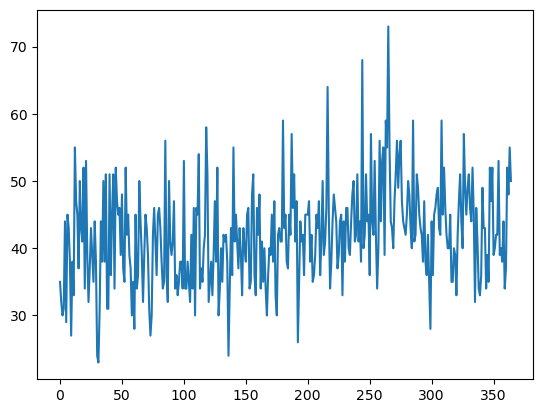

In [9]:
df.Count.plot()

In [73]:
series = df.Count
series = boxcox(series, 0) #cтабилизируем дисперсию
series = series[12:] - series[:-12] #убираем сезонность
series = series[1:] - series[:-1]
series = pd.Series(series)
series = series.astype(float)

<Axes: >

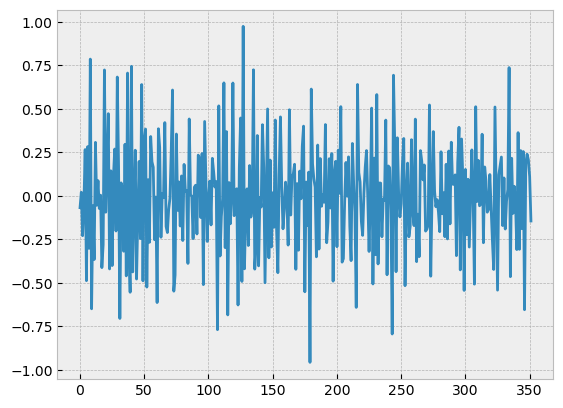

In [75]:
pd.Series(series).plot()

In [77]:
am = arch_model(series)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     32,   Neg. LLF: 92.95589901547065
Iteration:     10,   Func. Count:     56,   Neg. LLF: 92.94533058924377
Optimization terminated successfully    (Exit mode 0)
            Current function value: 92.94533055594192
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -92.9453
Distribution:                  Normal   AIC:                           193.891
Method:            Maximum Likelihood   BIC:                           209.345
                                        No. Observations:                  352
Date:                Sun, Oct 27 2024   Df Residuals:                      351
Time:          

In [79]:
# Функция для поиска лучшей модели ARIMA
def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    # Указываем тренд при создании модели
                    tmp_mdl = smta.ARIMA(TS, order=(i, d, j)).fit()
                    tmp_aic = tmp_mdl.aic

                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except Exception as e:
                    #print(f'Error for order {(i, d, j)}: {e}')
                    continue
    print('Best model: aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

# Поиск лучшей модели ARIMA
aic, order, mdl = _get_best_model(pd.Series(series))

Best model: aic: -5.36755 | order: (2, 0, 4)


In [81]:
p_ = 2
o_ = 0
q_ = 4

# Использование распределения Стьюдента для улучшения подгонки
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -91.3623
Distribution:      Standardized Student's t   AIC:                           200.725
Method:                  Maximum Likelihood   BIC:                           235.497
                                              No. Observations:                  352
Date:                      Sun, Oct 27 2024   Df Residuals:                      351
Time:                              23:24:59   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

In [83]:
# Функция для построения графиков остатков модели
def tsplot1(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, (pd.Series, np.ndarray)):
        y = np.array(y)

    plt.style.use(style)
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    ts_ax.plot(y)
    ts_ax.set_title('Residuals')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(10, 8))
    qq_ax = fig.add_subplot(111)
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('Q-Q plot')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.hist(y, bins=30, edgecolor='k')
    plt.title('Histogram of residuals')
    plt.show()

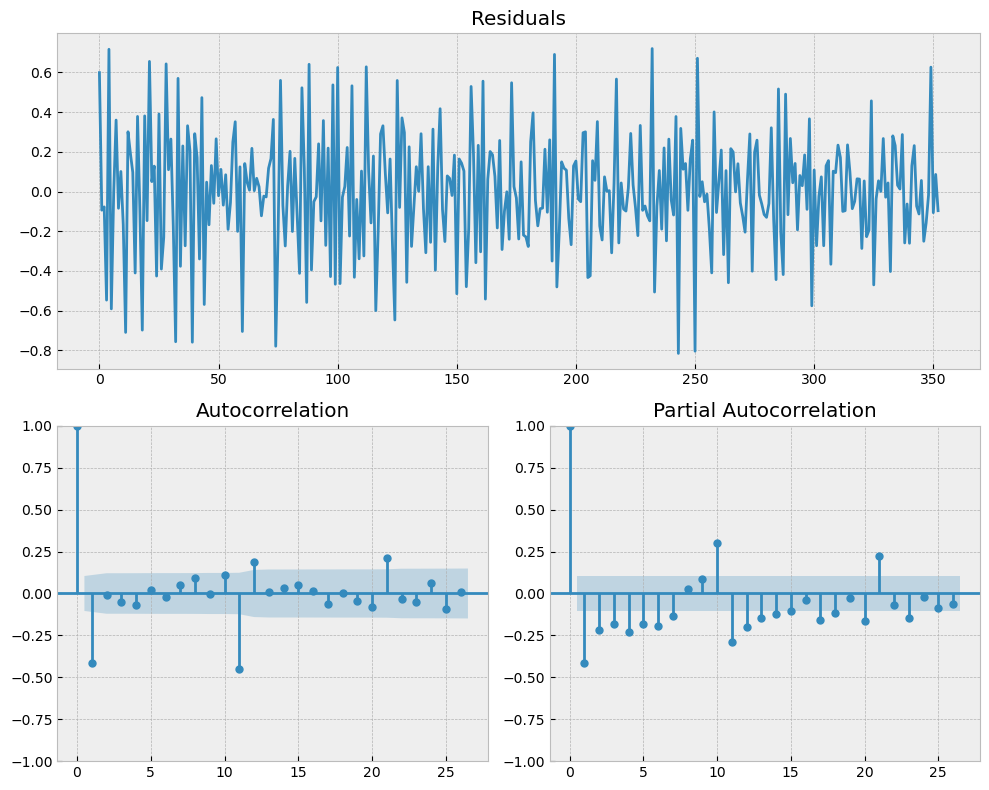

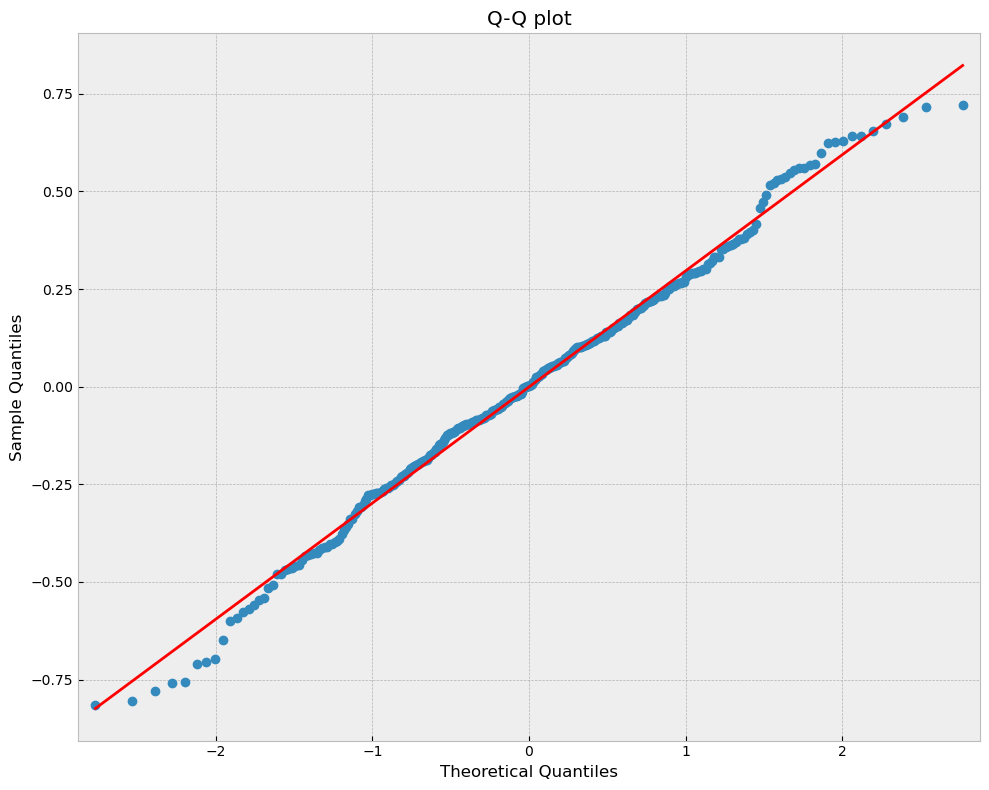

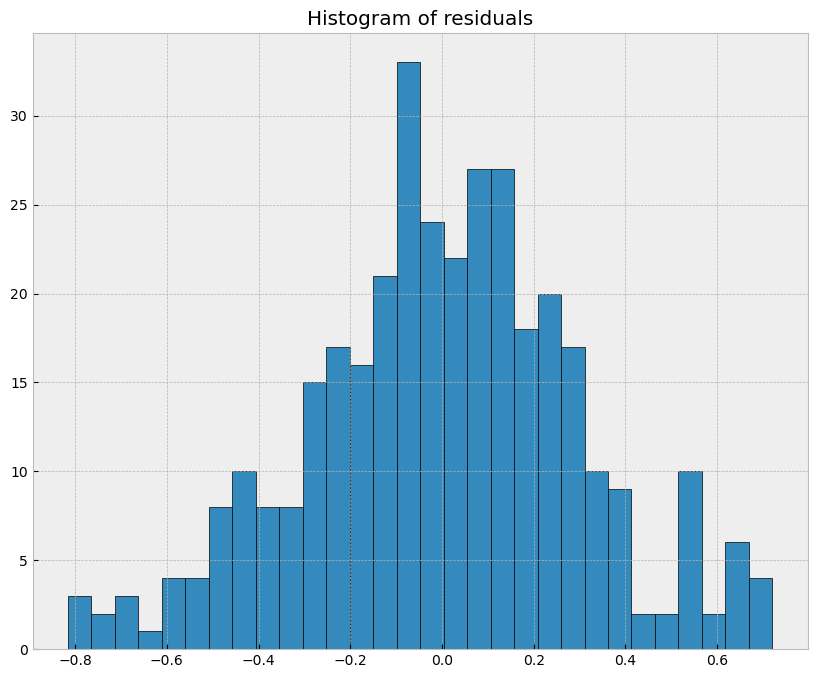

In [57]:
# Визуализация остатков модели GARCH
tsplot1(res.resid)